In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Load and Prepare Dataset


In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, usecols=[1])
dataset = df.values.astype('float32')

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create supervised learning format


In [3]:
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X, y = create_dataset(dataset, look_back)

# Reshape input to [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Train-test split (80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define LSTM Model

In [4]:
model_lstm = Sequential([
    LSTM(64, input_shape=(look_back, 1)),
    Dense(1)
])
model_lstm.compile(loss='mse', optimizer=Adam(0.01))

# Define BiLSTM Model

In [5]:
model_bilstm = Sequential([
    Bidirectional(LSTM(64, input_shape=(look_back, 1))),
    Dense(1)
])
model_bilstm.compile(loss='mse', optimizer=Adam(0.01))

# Train both models

In [6]:
# Train both models
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Evaluate models


In [7]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_bilstm = model_bilstm.predict(X_test)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_pred_bilstm_inv = scaler.inverse_transform(y_pred_bilstm)

# Compute RMSE
rmse_lstm = sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))
rmse_bilstm = sqrt(mean_squared_error(y_test_inv, y_pred_bilstm_inv))

print("Model Performance Comparison")
print(f"LSTM RMSE: {rmse_lstm:.3f}")
print(f"BiLSTM RMSE: {rmse_bilstm:.3f}")

r2_lstm = r2_score(y_test_inv, y_pred_lstm_inv)
r2_bilstm = r2_score(y_test_inv, y_pred_bilstm_inv)

1/1 [==============================] - 1s 956ms/step
Model Performance Comparison
LSTM RMSE: 44.258
BiLSTM RMSE: 38.658


# Visualization


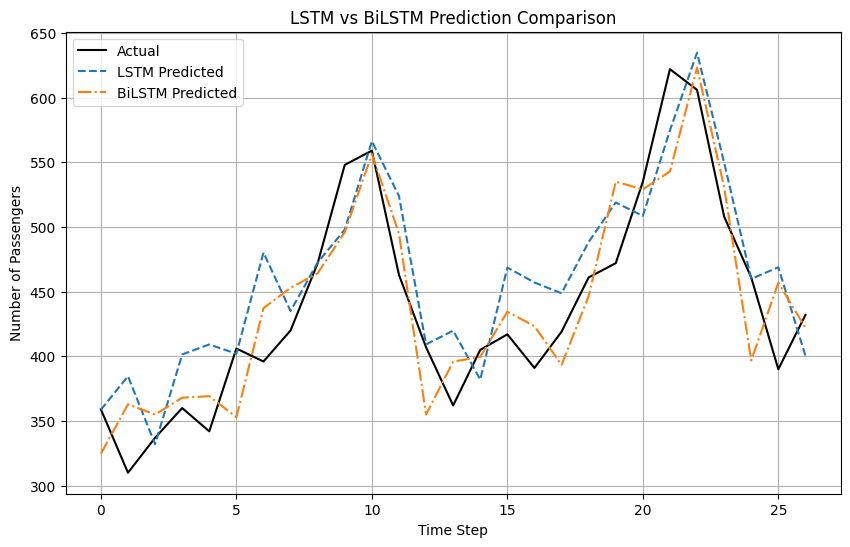

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual', color='black')
plt.plot(y_pred_lstm_inv, label='LSTM Predicted', linestyle='--')
plt.plot(y_pred_bilstm_inv, label='BiLSTM Predicted', linestyle='dashdot')
plt.title("LSTM vs BiLSTM Prediction Comparison")
plt.xlabel("Time Step")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(True)
plt.show()

# Training loss


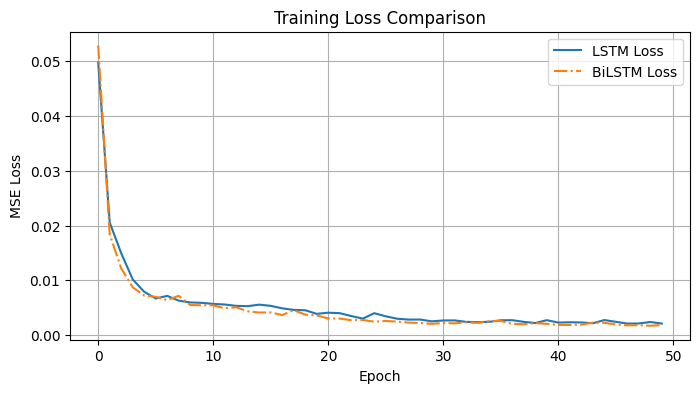

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history['loss'], label='LSTM Loss')
plt.plot(history_bilstm.history['loss'], label='BiLSTM Loss', linestyle='dashdot')
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

# Additional Metrics (MAE and R²)

In [12]:

mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
mae_bilstm = mean_absolute_error(y_test_inv, y_pred_bilstm_inv)

print("\n Detailed Metric Comparison")
print(f"{'Metric':<8} | {'LSTM':>12} | {'BiLSTM':>12}")
print("-" * 38)
print(f"RMSE     | {rmse_lstm:>12.3f} | {rmse_bilstm:>12.3f}")
print(f"MAE      | {mae_lstm:>12.3f} | {mae_bilstm:>12.3f}")
print(f"R² Score | {r2_lstm:>12.3f} | {r2_bilstm:>12.3f}")


 Detailed Metric Comparison
Metric   |         LSTM |       BiLSTM
--------------------------------------
RMSE     |       44.258 |       38.658
MAE      |       35.969 |       32.307
R² Score |        0.692 |        0.765
